## Ofertas Relâmpago

O objetivo desta análise é de se obter, de maneira simples e utilizando EDA, a resposta para a seguinte pergunta: 

Qual o melhor período para se anunciar uma oferta-relâmpago de um produto de determinada categoria?


Insight obtido após EDA: O período noturno é o melhor momento para a disponibilização das oferta-relâmpago, com exceção aos alimentos, que apresentam maior porcentagem de venda no período vespertino (tarde)

#### 1 - Importação dos Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df_raw = pd.read_csv('data/ofertas_relampago.csv')
df_preprocessing = df_raw.copy()
df_preprocessing.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


#### 2 - Limpeza dos Dados

##### 2.1 - Verificação e tratamento dos valores Nulos

In [3]:
df_preprocessing.isna().sum()

OFFER_START_DATE                 0
OFFER_START_DTTM                 0
OFFER_FINISH_DTTM                0
OFFER_TYPE                       0
INVOLVED_STOCK                   0
REMAINING_STOCK_AFTER_END        0
SOLD_AMOUNT                  24167
SOLD_QUANTITY                24167
ORIGIN                       37430
SHIPPING_PAYMENT_TYPE            0
DOM_DOMAIN_AGG1                  0
VERTICAL                         0
DOMAIN_ID                        0
dtype: int64

In [4]:
df_preprocessing['ORIGIN'] = df_preprocessing['ORIGIN'].fillna('NA')
df_preprocessing['SOLD_AMOUNT'] = df_preprocessing['SOLD_AMOUNT'].fillna(0)
df_preprocessing['SOLD_QUANTITY'] = df_preprocessing['SOLD_QUANTITY'].fillna(0)
print(df_preprocessing.isna().sum())

OFFER_START_DATE             0
OFFER_START_DTTM             0
OFFER_FINISH_DTTM            0
OFFER_TYPE                   0
INVOLVED_STOCK               0
REMAINING_STOCK_AFTER_END    0
SOLD_AMOUNT                  0
SOLD_QUANTITY                0
ORIGIN                       0
SHIPPING_PAYMENT_TYPE        0
DOM_DOMAIN_AGG1              0
VERTICAL                     0
DOMAIN_ID                    0
dtype: int64


##### 2.2 - Verificação e Tratamento dos Valores Duplicados

In [5]:
print(len(df_preprocessing.loc[df_preprocessing.duplicated(keep=False)]))

1708


In [6]:
df_preprocessing = df_preprocessing.drop_duplicates()
len(df_preprocessing.loc[df_preprocessing.duplicated()])

0

#### 3 - Engenharia de Features

3.1 - Criação de feature de porcentagens para a quantidade de vendas

In [7]:
df = df_preprocessing.copy()

In [8]:
df['SOLD_PERCENTAGE'] = round((df['SOLD_QUANTITY'] / df['INVOLVED_STOCK']),2)
df.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,1.50
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00


##### 3.2 - Criação de feature categórica para tempo de oferta relâmpago

In [9]:
df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])
df['OFFER_FINISH_DTTM'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])

df['TIME_DIFF'] = df['OFFER_FINISH_DTTM'] - df['OFFER_START_DTTM']
labels = ['Entre 0 e 5 minutos','Entre 5 minutos e 1 hora', 'Entre 1 e 4 horas', 'Entre 4 e 6 horas', 'Entre 6 e 8 horas', 'Acima de 8 horas']
bins = [pd.Timedelta(0), pd.Timedelta(minutes=5),pd.Timedelta(hours=1), pd.Timedelta(hours=4), pd.Timedelta(hours=6), pd.Timedelta(hours=8), pd.Timedelta.max]

df['TIME_SPAN'] = pd.cut(df['TIME_DIFF'], bins=bins, labels=labels, right=False)
df.head(5)


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,1.50,0 days 07:02:43,Entre 6 e 8 horas
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00,0 days 06:00:02,Entre 6 e 8 horas
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20,0 days 06:00:01,Entre 6 e 8 horas
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13,0 days 06:36:12,Entre 6 e 8 horas
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00,0 days 02:48:12,Entre 1 e 4 horas


<AxesSubplot: >

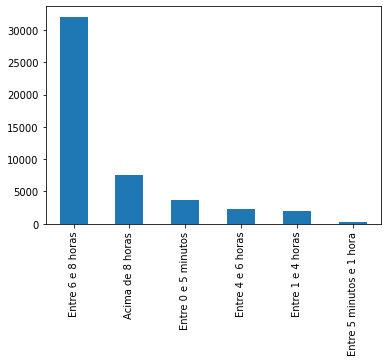

In [10]:
df['TIME_SPAN'].value_counts().plot(kind='bar')

##### 3.3 - Criação de feature categórica para períodos de tempo de início da oferta relâmpago

In [11]:
df['OFFER_START_DTTM_HOUR'] = df['OFFER_START_DTTM'].dt.hour
df['OFFER_FINISH_DTTM_HOUR'] = df['OFFER_FINISH_DTTM'].dt.hour

bins = [0, 12, 18, 24]
labels = ['Manhã', 'Tarde', 'Noite']
df['OFFER_START_PERIOD'] = pd.cut(df['OFFER_START_DTTM_HOUR'], bins=bins, labels=labels, right=False)
df['OFFER_FINISH_PERIOD'] = pd.cut(df['OFFER_FINISH_DTTM_HOUR'], bins=bins, labels=labels, right=False)
df.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN,OFFER_START_DTTM_HOUR,OFFER_FINISH_DTTM_HOUR,OFFER_START_PERIOD,OFFER_FINISH_PERIOD
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS,1.50,0 days 07:02:43,Entre 6 e 8 horas,16,23,Tarde,Noite
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00,0 days 06:00:02,Entre 6 e 8 horas,13,19,Tarde,Noite
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20,0 days 06:00:01,Entre 6 e 8 horas,7,13,Manhã,Tarde
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13,0 days 06:36:12,Entre 6 e 8 horas,19,1,Noite,Manhã
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00,0 days 02:48:12,Entre 1 e 4 horas,13,15,Tarde,Tarde


<AxesSubplot: >

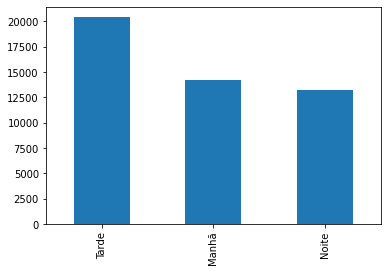

In [12]:
df['OFFER_START_PERIOD'].value_counts().plot(kind='bar')

#### 4 - Filtros dos Dados
Através das Features obtidas, pôde-se notar algumas características que devem ser analisadas cuidadosamente.

#### 4.1 - Filtros de tempo de ofertas relâmpago
Nota-se a ocorrência de ofertas no período entre 0 e 5 minutos que não obtiveram nenhuma venda, como indica o gráfico abaixo.
Comportamento sugere erros de sistema ou produtos que foram retirados da oferta imediatamente.
Para garantir a confiabilidade dos dados, esses valores serão retirados da análise

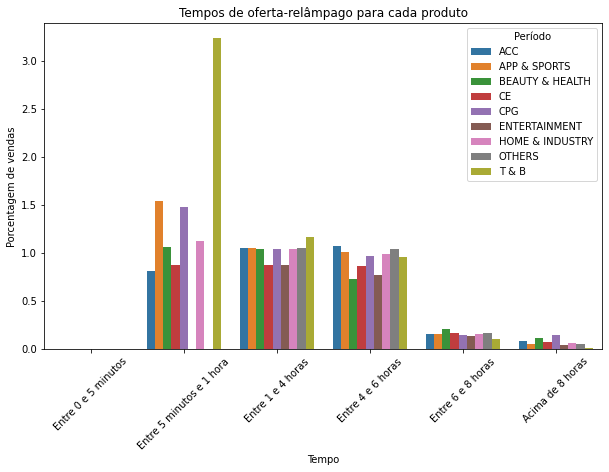

In [13]:
df_timespan = df.groupby(['TIME_SPAN', 'VERTICAL'])['SOLD_PERCENTAGE'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='TIME_SPAN', y='SOLD_PERCENTAGE', hue='VERTICAL', data=df_timespan)
plt.title('Tempos de oferta-relâmpago para cada produto')
plt.xlabel('Tempo')
plt.ylabel('Porcentagem de vendas')
plt.legend(title='Período')
plt.xticks(rotation=45)
plt.show()


In [14]:
df = df.loc[df['TIME_SPAN'] != 'Entre 0 e 5 minutos']
df['TIME_SPAN'].value_counts()

Entre 6 e 8 horas           32044
Acima de 8 horas             7506
Entre 4 e 6 horas            2363
Entre 1 e 4 horas            1921
Entre 5 minutos e 1 hora      238
Entre 0 e 5 minutos             0
Name: TIME_SPAN, dtype: int64

In [15]:
len(df)

44072

#### 4.2 - Filtro de Inconsistências
Nota-se também no gráfico a ocorrência de outliers e porcentagens que não fazem sentido.

Filtrando as porcentagens elevadas, obtemos valores negativos no estoque final.

In [16]:
df.loc[df['SOLD_PERCENTAGE'] > 1].sort_values(by='REMAINING_STOCK_AFTER_END', ascending=True).head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN,OFFER_START_DTTM_HOUR,OFFER_FINISH_DTTM_HOUR,OFFER_START_PERIOD,OFFER_FINISH_PERIOD
32275,2021-07-15,2021-07-15 19:00:00+00:00,2021-07-15 21:50:19+00:00,lightning_deal,15,-192,893.26,207.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,13.80,0 days 02:50:19,Entre 1 e 4 horas,19,21,Noite,Noite
11448,2021-07-27,2021-07-27 12:00:00+00:00,2021-07-27 15:50:59+00:00,lightning_deal,124,-81,681.59,205.0,A,none,BEAUTY EQUIPMENT,BEAUTY & HEALTH,MLM-DISPOSABLE_GLOVES,1.65,0 days 03:50:59,Entre 1 e 4 horas,12,15,Tarde,Tarde
41045,2021-06-15,2021-06-15 13:00:00+00:00,2021-06-15 13:26:57+00:00,lightning_deal,5,-70,60.86,65.0,NA,none,TOYS AND GAMES,T & B,MLM-TOYS_AND_GAMES,13.00,0 days 00:26:57,Entre 5 minutos e 1 hora,13,13,Tarde,Tarde
45648,2021-07-26,2021-07-26 22:00:00+00:00,2021-07-26 23:05:13+00:00,lightning_deal,200,-41,801.61,241.0,A,none,BEAUTY EQUIPMENT,BEAUTY & HEALTH,MLM-DISPOSABLE_GLOVES,1.20,0 days 01:05:13,Entre 1 e 4 horas,22,23,Noite,Noite
32845,2021-07-15,2021-07-15 13:00:00+00:00,2021-07-15 17:10:31+00:00,lightning_deal,15,-39,94.24,54.0,NA,none,PHARMACEUTICS,BEAUTY & HEALTH,MLM-OIL_DIFFUSERS,3.60,0 days 04:10:31,Entre 4 e 6 horas,13,17,Tarde,Tarde


Seria questionado para a área responsável o motivo da ocorrência destes valores negativos. Por ora, removemos estes valores da análise

In [17]:
df = df.loc[df['SOLD_PERCENTAGE'] <= 1]
df.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN,OFFER_START_DTTM_HOUR,OFFER_FINISH_DTTM_HOUR,OFFER_START_PERIOD,OFFER_FINISH_PERIOD
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00,0 days 06:00:02,Entre 6 e 8 horas,13,19,Tarde,Noite
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20,0 days 06:00:01,Entre 6 e 8 horas,7,13,Manhã,Tarde
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13,0 days 06:36:12,Entre 6 e 8 horas,19,1,Noite,Manhã
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00,0 days 02:48:12,Entre 1 e 4 horas,13,15,Tarde,Tarde
5,2021-06-22,2021-06-22 18:00:00+00:00,2021-06-23 01:00:12+00:00,lightning_deal,23,23,0.00,0.0,A,free_shipping,COMPUTERS,CE,MLM-HEADPHONES,0.00,0 days 07:00:12,Entre 6 e 8 horas,18,1,Noite,Manhã


Nota-se também que a coluna de itens vendidos não necessariamente condiz com a diferença das colunas de fim de estoque e início de estoque.

In [18]:
df.loc[(df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END']) != df['SOLD_QUANTITY']]
df.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN,OFFER_START_DTTM_HOUR,OFFER_FINISH_DTTM_HOUR,OFFER_START_PERIOD,OFFER_FINISH_PERIOD
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00,0 days 06:00:02,Entre 6 e 8 horas,13,19,Tarde,Noite
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20,0 days 06:00:01,Entre 6 e 8 horas,7,13,Manhã,Tarde
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13,0 days 06:36:12,Entre 6 e 8 horas,19,1,Noite,Manhã
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00,0 days 02:48:12,Entre 1 e 4 horas,13,15,Tarde,Tarde
5,2021-06-22,2021-06-22 18:00:00+00:00,2021-06-23 01:00:12+00:00,lightning_deal,23,23,0.00,0.0,A,free_shipping,COMPUTERS,CE,MLM-HEADPHONES,0.00,0 days 07:00:12,Entre 6 e 8 horas,18,1,Noite,Manhã


Comportamento supõe erro de sistema ou movimentação fora do procedimento automatizado. Este seria questionado com área responsável para sua compreensão. Por ora, iremos remover estes valores.

In [19]:
df.loc[(df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END']) == df['SOLD_QUANTITY']]
df.head(5)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,SOLD_PERCENTAGE,TIME_DIFF,TIME_SPAN,OFFER_START_DTTM_HOUR,OFFER_FINISH_DTTM_HOUR,OFFER_START_PERIOD,OFFER_FINISH_PERIOD
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0.0,NA,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS,0.00,0 days 06:00:02,Entre 6 e 8 horas,13,19,Tarde,Noite
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NA,none,COMPUTERS,CE,MLM-SPEAKERS,0.20,0 days 06:00:01,Entre 6 e 8 horas,7,13,Manhã,Tarde
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,0.13,0 days 06:36:12,Entre 6 e 8 horas,19,1,Noite,Manhã
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NA,none,COMPUTERS,CE,MLM-HEADPHONES,1.00,0 days 02:48:12,Entre 1 e 4 horas,13,15,Tarde,Tarde
5,2021-06-22,2021-06-22 18:00:00+00:00,2021-06-23 01:00:12+00:00,lightning_deal,23,23,0.00,0.0,A,free_shipping,COMPUTERS,CE,MLM-HEADPHONES,0.00,0 days 07:00:12,Entre 6 e 8 horas,18,1,Noite,Manhã


#### 4.3 - Balanceamento das Classes por período

A distribuição dos períodos não é homogênea. Para garantir a homogeneidade dos dados na análise por período, convém distribuir as classes analisadas igualmente. Além disso, filtraremos somente as informações utilizadas na análise.

<AxesSubplot: >

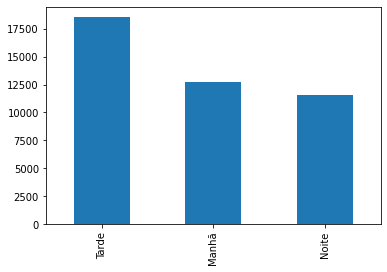

In [20]:
df['OFFER_START_PERIOD'].value_counts().plot(kind='bar')

In [21]:
rus = RandomUnderSampler(random_state=42)
X = df[['VERTICAL', 'TIME_SPAN', 'SOLD_PERCENTAGE']]
y = df[['OFFER_START_PERIOD']]
X_resampled, y_resampled = rus.fit_resample(X,y)
df_analyse = pd.concat([X_resampled, y_resampled], axis=1)
df_analyse.head(5)


,VERTICAL,TIME_SPAN,SOLD_PERCENTAGE,OFFER_START_PERIOD
3914,BEAUTY & HEALTH,Acima de 8 horas,0.08,Manhã
32198,ACC,Entre 6 e 8 horas,0.00,Manhã
15446,CE,Entre 6 e 8 horas,0.00,Manhã
25976,HOME & INDUSTRY,Acima de 8 horas,0.05,Manhã
45617,BEAUTY & HEALTH,Entre 6 e 8 horas,0.00,Manhã


<AxesSubplot: >

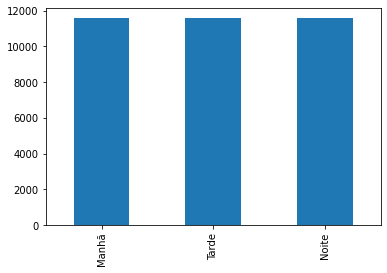

In [22]:
df_analyse['OFFER_START_PERIOD'].value_counts().plot(kind='bar')

Assim, após filtragem e rebalanceamento dos dados, obtem-se a distribuição abaixo:

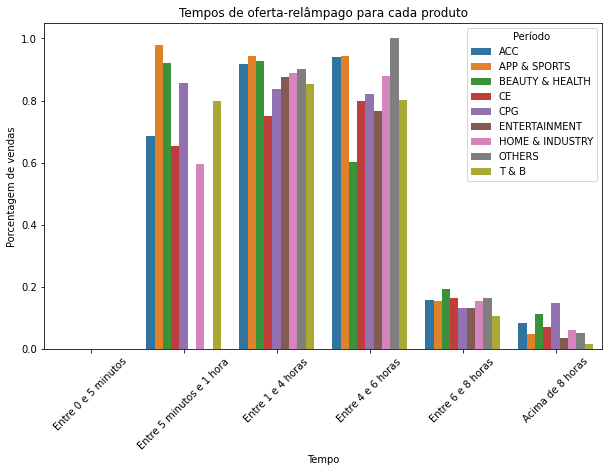

In [23]:
df_timespan_balanced = df.groupby(['TIME_SPAN', 'VERTICAL'])['SOLD_PERCENTAGE'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='TIME_SPAN', y='SOLD_PERCENTAGE', hue='VERTICAL', data=df_timespan_balanced)
plt.title('Tempos de oferta-relâmpago para cada produto')
plt.xlabel('Tempo')
plt.ylabel('Porcentagem de vendas')
plt.legend(title='Período')
plt.xticks(rotation=45)
plt.show()

#### 5 - Análise dos Resultados

Verificamos a resposta para a pergunta definida no objetivo desta análise: Qual o melhor momento do dia para a venda de um determinado tipo de produto?

##### 5.1 - Visualização dos dados
Verifica-se a porcentagem de vendas por tipo de produto para cada período no gráfico abaixo


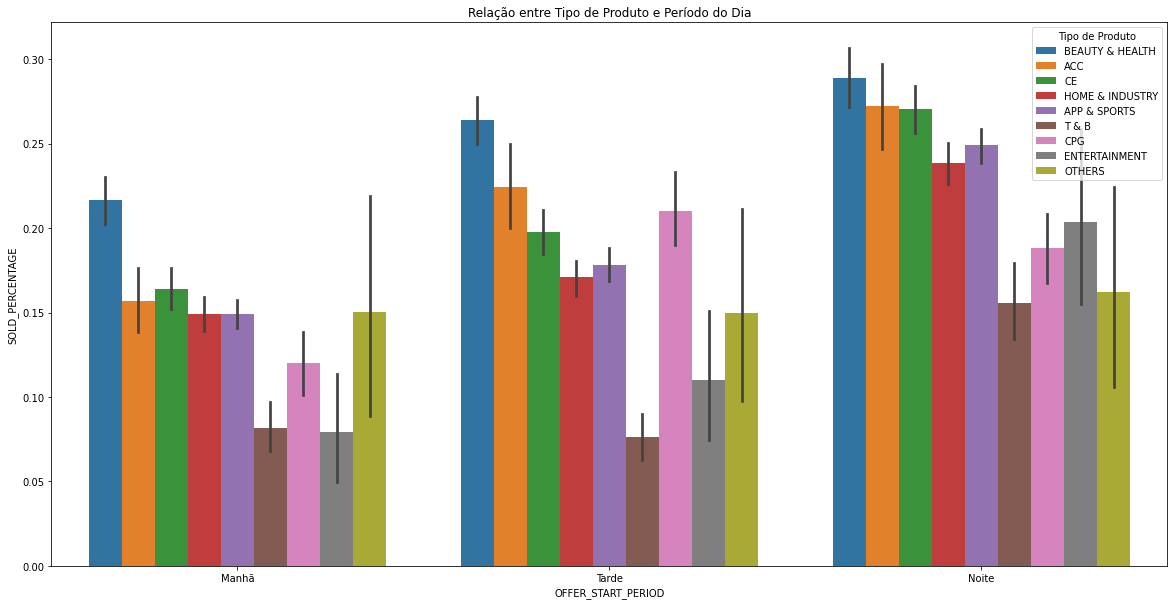

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x='OFFER_START_PERIOD', y='SOLD_PERCENTAGE',hue='VERTICAL',data=df_analyse)
plt.title('Relação entre Tipo de Produto e Período do Dia')
plt.legend(title='Tipo de Produto', loc='upper right')
plt.show()

Assim, obtemos uma tabela com os melhores períodos para se anunciar uma oferta-relâmpago

In [25]:
df_best_periods = df_analyse.groupby(['OFFER_START_PERIOD', 'VERTICAL'])['SOLD_PERCENTAGE'].mean().reset_index()
df_best_periods = df_best_periods.sort_values(by='SOLD_PERCENTAGE', ascending=False)
df_best_periods = df_best_periods.groupby('VERTICAL').first().reset_index()
df_best_periods

,VERTICAL,OFFER_START_PERIOD,SOLD_PERCENTAGE
0,ACC,Noite,0.272240
1,APP & SPORTS,Noite,0.249071
2,BEAUTY & HEALTH,Noite,0.288845
3,CE,Noite,0.270401
4,CPG,Tarde,0.210341
5,ENTERTAINMENT,Noite,0.203692
6,HOME & INDUSTRY,Noite,0.238349
7,OTHERS,Noite,0.162308
8,T & B,Noite,0.155893


##### 5.2 - Insights

Observamos que os melhores momentos para o anuncio de um produto é o período noturno.

A exceção ocorre para os produtos alimentícios, que são melhores vendidos no período vespertino

Sugere-se como motivo desta ocorrência o consumo de alimentos no período vespertino em horário comercial, conciliando com o período noturno que também apresentou uma boa porcentagem de vendas. Ao fim do dia, o consumidor possui maior tempo disponível para a realização das compras

##### 5.3 Análises futuras

Para futuras análises, podemos fragmentar ainda mais os nossos dados, a fim de se obter insights sobre os sub-produtos

Além disso, a investigação dos dados inconsistêntes verificados acima podem reforçar e complementar as análises realizadas

Por fim, podemos também verificar outras influências que distribuem as vendas em determinados períodos, como a análise histórica para se obter comportamentos sazonais, tendências de mercado e outros fatores externos às análises

##### 6 - Exportação

Exportaremos os dados de maneira a ser consumido pela plataforma de visualização de dados apropriada. Para fins de simplificação, exportaremos em um arquivo Excel

In [26]:
df_best_periods = df_best_periods.rename(columns={'VERTICAL': 'Product', 'OFFER_START_PERIOD': 'Best Period', 'SOLD_PERCENTAGE': 'Sold (%)'})
df_best_periods.to_excel('output/best_periods.xlsx', index=False)